# EOF Analysis of NEMO surface tracers

***

In [192]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift

%matplotlib inline

***

## Load data

Concatenated at the command line using NCO

In [4]:
# Load netCDF files
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

In [5]:
# Characterize subgrid
xrange, yrange, skip = [115, 361], [310, 789], 2
gridx, gridy = np.meshgrid(ptrc.x[::skip], ptrc.y[::skip])
shape = gridx.shape
npoints = np.prod(shape)

# Construct flattened variables
tmask = mask.tmask[0, 0, slice(*yrange), slice(*xrange)].values[::skip, ::skip].reshape(npoints).astype(bool)
gridx = gridx.reshape(npoints)[tmask]
gridy = gridy.reshape(npoints)[tmask]
#nitrate = ptrc.nitrate[:, 0, ...].values[:, ::skip, ::skip].reshape(-1, npoints)[:, tmask]
nitrate = ptrc.nitrate[:, 0, 200, 100].values

***

## Filtering

Per Rich's recommendations, using a moving-average filter

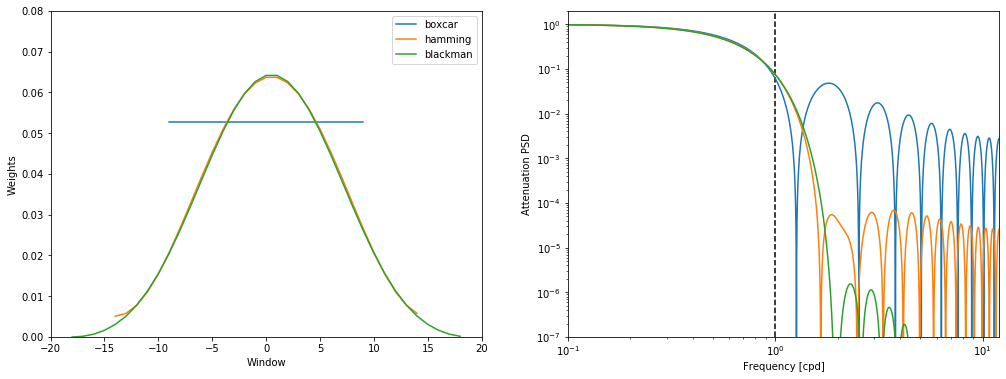

In [174]:
# ----- Examine filter properties ------

# Length of data record
n = len(nitrate)
freq = np.linspace(-12, 12, n)

# Make plots
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
lims = [(-20, 20, 0, 0.08), (1e-1, 12, 1e-7, 2)]
labels = [('Window', 'Weights'), ('Frequency [cpd]', 'Attenuation PSD')]
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot([1, 1], lims[1][2:], 'k--')
for ax, lim, label in zip(axs, lims, labels):
    ax.set_xlim(lim[:2])
    ax.set_ylim(lim[2:])
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

# Plot filters
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], [19, 29, 37]):
    w2 = (w - 1) / 2
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    PSD = abs(fftshift(fft(window, n)))**2
    axs[0].plot(np.linspace(-w2, w2, w), window, label=window_type)
    axs[1].plot(freq, PSD)

axs[0].legend()
plt.show()

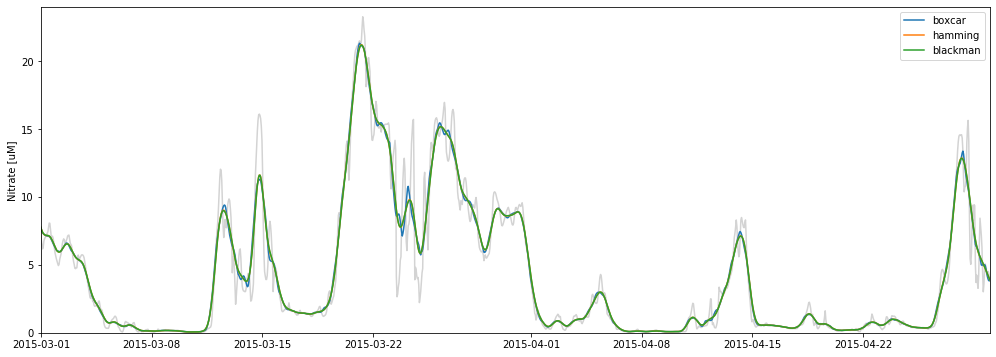

In [193]:
# ------ Apply filters to surface nitrate record ------

# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(ptrc.time_counter, nitrate, '-', color='lightgray')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')

# Plot filters
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], [19, 29, 37]):
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    ax.plot(ptrc.time_counter, signal.convolve(nitrate, window, mode='same'), label=window_type)
ax.legend()
plt.show()

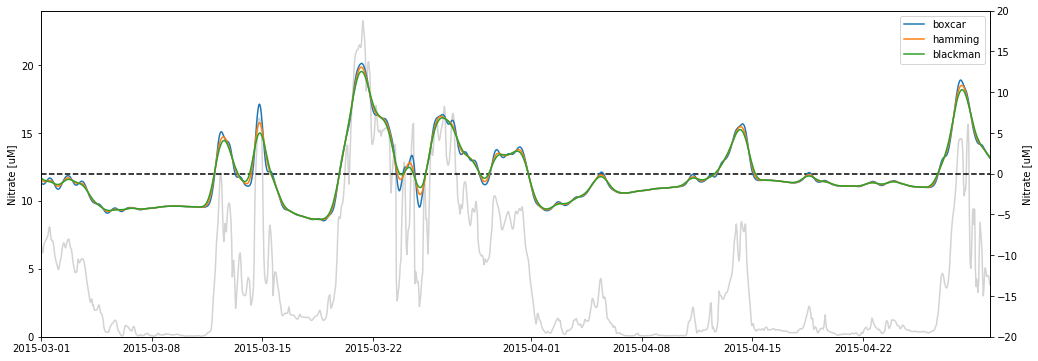

In [203]:
# ------ Subtract filters to construct bandpass ------

# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(ptrc.time_counter, nitrate, '-', color='lightgray')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot(xlim, [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], [19, 29, 37]):
    window = signal.get_window('hamming', w)
    window = window / sum(window)
    nitrate_bandpass = signal.convolve(nitrate, window, mode='same')
    window = signal.get_window('hamming', 721)
    window = window / sum(window)
    nitrate_bandpass -= signal.convolve(nitrate, window, mode='same')
    ax2.plot(ptrc.time_counter, nitrate_bandpass, label=window_type)
    
ax2.legend()
plt.show()